# Nino3.4_check
 - Check Nino3.4 prediction
 - data I/O functions based on template from daniel kennedy (djk2120@ucar.edu): https://github.com/djk2120/cesm-lens
 - Uses single open_mfdataset call with partial(preprocess) following @dcherian

In [1]:
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
from functools import partial
import glob
import dask
import matplotlib.pyplot as plt
%matplotlib inline

## Create Dask Cluster

In [66]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
cluster.close()
client.close()

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='10GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(30) 

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [4]:
cluster

### Data I/O functions:
 - Run each of these cells, then proceed to Main Processing
 - Note that these functions are designed to read monthly data

In [5]:
def file_dict(filetempl,filetype,mem,stmon):
    ''' returns a dictionary of filepaths keyed by initialization year, 
    for a given experiment, field, ensemble member, and initialization month '''
    memstr = '{0:03d}'.format(mem)
    monstr = '{0:02d}'.format(stmon)
    filepaths = {}
    
    filetemp = filetempl.replace('MM',monstr).replace('EEE',memstr)

    #find all the relevant files
    files = sorted(glob.glob(filetemp))
        
    for file in files:
        #isolate initialization year from the file name
        ystr = file.split(filetype)[0]
        y0 = int(ystr[-11:-7])
        filepaths[y0]=file
        
    return filepaths

In [6]:
def nested_file_list_by_year(filetemplate,filetype,ens,field,firstyear,lastyear,stmon):
    ''' retrieve a nested list of files for these start years and ensemble members'''
    ens = np.array(range(ens))+1
    yrs = np.arange(firstyear,lastyear+1)
    files = []    # a list of lists, dim0=start_year, dim1=ens
    ix = np.zeros(yrs.shape)+1
    
    for yy,i in zip(yrs,range(len(yrs))):
        ffs = []  # a list of files for this yy
        file0 = ''
        first = True
        for ee in ens:
            filepaths = file_dict(filetemplate,filetype,ee,stmon)
            #append file if it is new
            if yy in filepaths.keys():
                file = filepaths[yy]
                if file != file0:
                    ffs.append(file)
                    file0 = file
        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,yrs[ix==1]

In [7]:
## NOTE
## Regulate dask array size using this proprocess function.
## Set appropriately based on analysis to come.
## E.g., currently set to extract POP surface layer and 24 months of data
def preprocess_smyle(ds0,nlead,field):
    """ This is applied on an individual file basis."""
    d0 = ds0.isel(z_t=0).isel(time=slice(0, nlead))

    # quick fix to adjust time vector for monthly data
    nmonths = len(d0.time)
    yr0 = d0["time.year"][0].values
    d0["time"] = xr.cftime_range(str(yr0), periods=nmonths, freq="MS")

    # DC: Can't assign M yet since we have a single file = 1 member
    # d0 = d0.assign_coords(M=("M", np.arange(sizes["M"])))
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.reset_coords(["time"])

    # DC: explicitly add the dimension Y so xarray knows to concatenate time variables also
    # if you know what Y should be, you could do `.expand_dims(Y=[year])`
    #    - d0.encoding["source"] is the file name, which might be useful for setting some 
    #      coordinate values
    # you could also do this with TEMP to be really explicit about what you want.
    # Because you pass data_vars=["TEMP"], xarray will do expand_dims on TEMP for you.
    d0["time"] = d0.time.expand_dims("Y")
    d0["time_bound"] = d0.time_bound.expand_dims("Y")

    # DC: subset as in the original code but not necessary
    # does speed things up.
    #return d0[["time", "time_bound", field, "TAREA", "UAREA"]]
    return d0


In [8]:
def get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,stmon,chunks={}):
    ''' returns dask array containing the requested hindcast ensemble '''

    file_list,yrs = nested_file_list_by_year(filetemplate,filetype,ens,field,firstyear,lastyear,stmon)

    ds0 = xr.open_mfdataset(
    file_list,
    combine="nested",
    # concat_dim depends on how file_list is ordered; 
    # inner most list of datasets is combined along "M"; 
    # then the outer list is combined along "Y"
    concat_dim=["Y","M"],
    parallel=True,
    data_vars=[field],
    coords="minimal",
    compat="override",
    preprocess=partial(preprocess_smyle,nlead=nlead,field=field))
    
    # assign final attributes
    ds0["Y"] = yrs
    ds0["M"] = np.arange(ds0.sizes["M"]) + 1
    
    # reorder into desired format (Y,L,M,...)
    ds0 = ds0.transpose("Y","L","M",...)
    return ds0

# Main Processing

### Read in POP monthly field
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead month)
- "time" and "time_bound" variables, which give prediction verification time, are also dimensioned with (Y,L) 

In [10]:
%%time
# SMYLE data
# process all 20 ensemble members, all November start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 11
#chunks={'z_t':1,'nlat':80}
smyle11_temp = get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth)
smyle11_temp.nbytes/1e9 #GB

CPU times: user 28.1 s, sys: 11.1 s, total: 39.3 s
Wall time: 42.2 s


11.581230148

In [11]:
# Full array can fit in distributed memory, so call persist
# This takes time up front, but speeds things up later
smyle11_temp = smyle11_temp.persist()

In [12]:
%%time
# SMYLE data
# process all 20 ensemble members, all November start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 2
#chunks={'z_t':1,'nlat':80}
smyle02_temp = get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth)
smyle02_temp.nbytes/1e9 #GB

CPU times: user 31.9 s, sys: 11.5 s, total: 43.4 s
Wall time: 1min 9s


11.581230148

In [13]:
smyle02_temp = smyle02_temp.persist()

In [15]:
%%time
# SMYLE data
# process all 20 ensemble members, all November start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 8
#chunks={'z_t':1,'nlat':80}
smyle08_temp = get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth)
smyle08_temp.nbytes/1e9 #GB

ValueError: The supplied objects do not form a hypercube because sub-lists do not have consistent lengths along dimension0

### Compute Nino3.4 Index

In [16]:
def POP_regional_areawgt(ds,lon_lim,lat_lim):
    tarea = ds.TAREA
    tlat = ds.TLAT
    tlon = xr.where(ds.TLONG>180.,ds.TLONG-360.,ds.TLONG)
    region = (tlat>=lat_lim[0]) & (tlat<=lat_lim[1]) & (tlon>=lon_lim[0]) & (tlon<=lon_lim[1])
    return xr.where(region,tarea.fillna(0),0)

In [17]:
POPg16_nino34_area = POP_regional_areawgt(smyle_temp,[-170.,-120.],[-5.,5])

Here, perform actual computation, returning xarray:

In [18]:
%%time
smyle11_nino34 = smyle11_temp.TEMP.weighted(POPg16_nino34_area).mean(("nlon", "nlat")).load()
smyle11_time_bound = smyle11_temp.time_bound.load()

CPU times: user 4.44 s, sys: 67.9 ms, total: 4.51 s
Wall time: 4.72 s


In [19]:
%%time
smyle02_nino34 = smyle02_temp.TEMP.weighted(POPg16_nino34_area).mean(("nlon", "nlat")).load()
smyle02_time_bound = smyle02_temp.time_bound.load()

CPU times: user 4.51 s, sys: 47 ms, total: 4.56 s
Wall time: 5.1 s


In [20]:
# Observed Nino3.4 (NOAA ERSSTv5)
ds_obs = xr.open_dataset('/glade/p/cgd/oce/people/yeager/obs/SST/NOAA_ERSSTv5/ersst.v5.188001-202012.gx1v6.nc',decode_times=False)
obs_time_vals = [cftime.DatetimeNoLeap(1880+year, 1+month, 15) for year in range(141) for month in range(12)]
ds_obs['time'] = obs_time_vals
obs_nino34 = ds_obs.sst.weighted(POPg16_nino34_area).mean(("nlon", "nlat")).load()

### Generate Time Series Plot
- For some reason, I can't get `errorbar` or `scatter` plot methods to handle the cftime.DatetimeNoLeap time values. `plot` can handle it. 
The error message reports it needs cftime.datetime objects, but isinstance(smyletime.values[0],cftime.datetime) returns True.

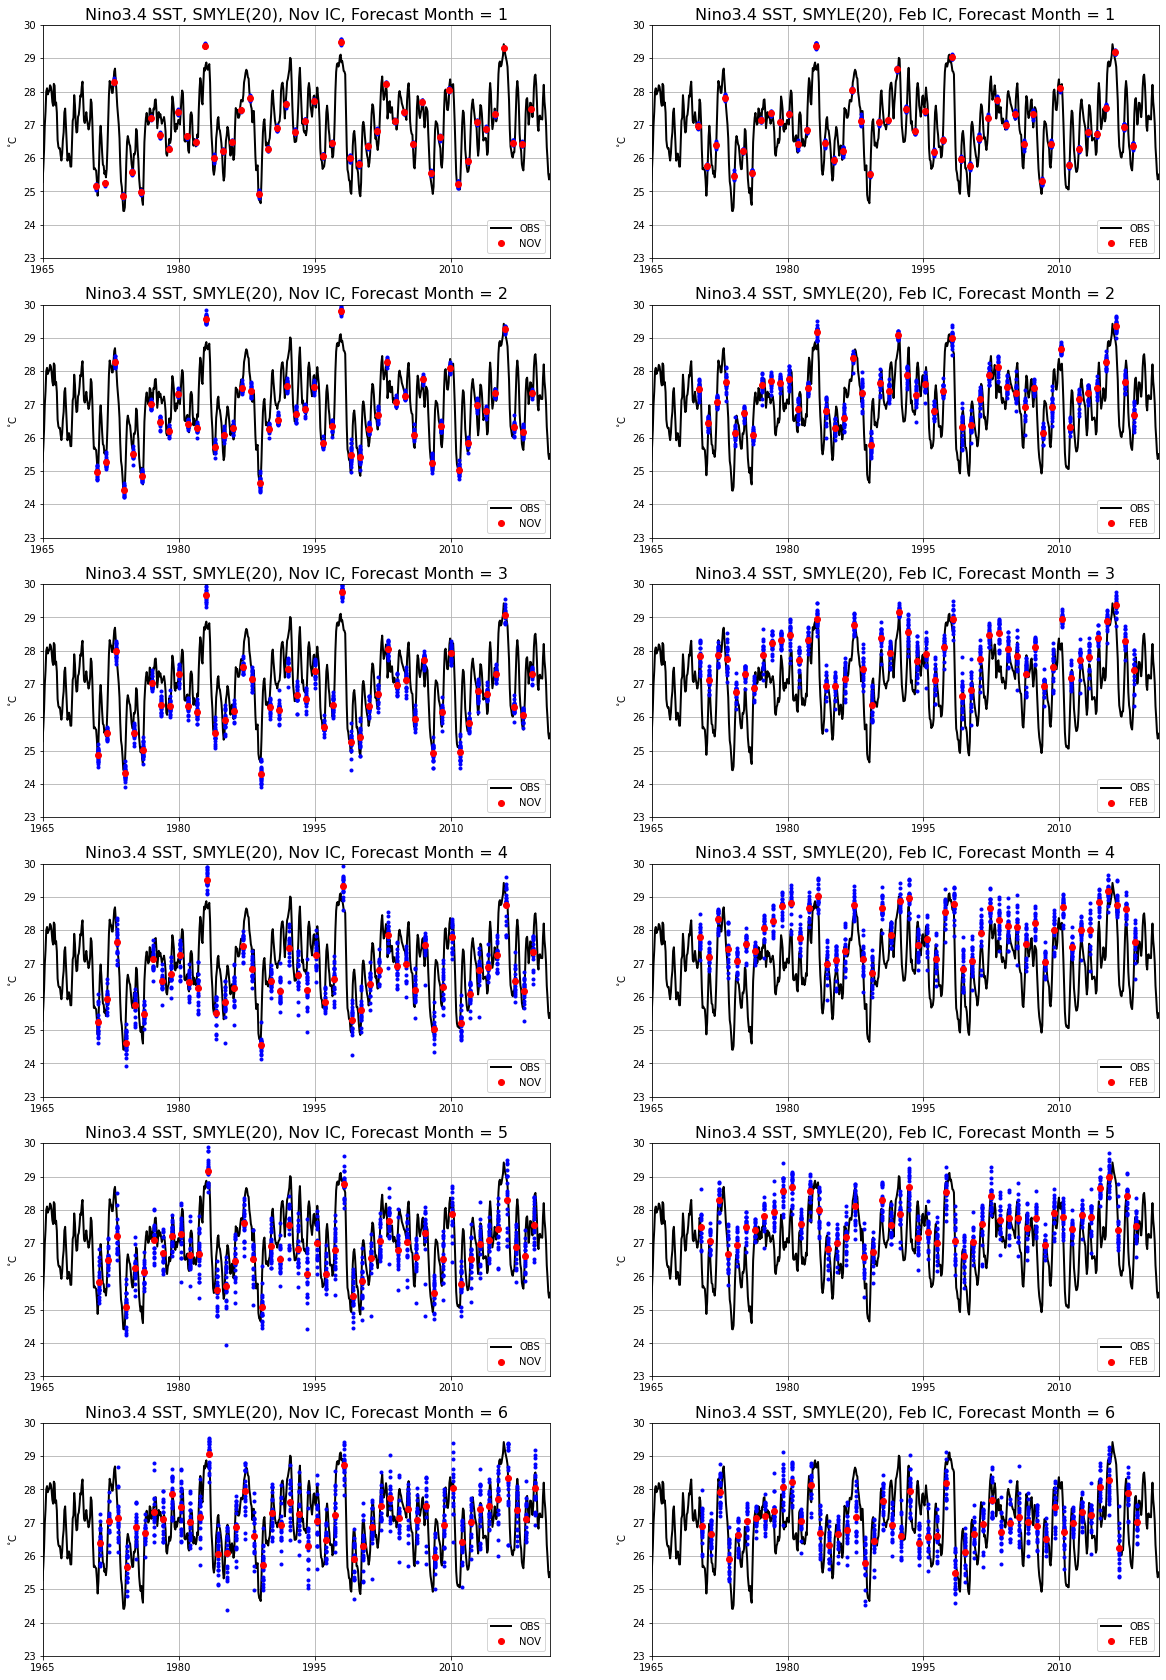

In [21]:
nlead = 6
fig = plt.figure(figsize=(20, nlead*5))
nrow = nlead
ncol = 2

xtickyears = [1960,1965,1975,1985,1995,2005,2015]
xticks = [cftime.num2date(0, 'days since '+str(i)+'-01-01 00:00:00', calendar='noleap') for i in xtickyears]
xmin = cftime.num2date(0, 'days since 1965-01-01 00:00:00', calendar='noleap')
xmax = cftime.num2date(0, 'days since 2021-01-01 00:00:00', calendar='noleap')

for i in range(nlead):
    thislead = i+1
    smyle11time = smyle11_time_bound.sel(L=thislead).mean('d2')
    ax = fig.add_subplot(nrow,ncol,i*ncol+1)
    ax.plot(obs_nino34.time, obs_nino34,linewidth=2,color='k',label='OBS')
    ax.plot(smyle11time,smyle11_nino34.sel(L=thislead),'.',color='b')
    ax.plot(smyle11time,smyle11_nino34.sel(L=thislead).mean('M'),'o',color='r',label='NOV')
    ax.grid()
    ax.set_title('Nino3.4 SST, SMYLE(20), Nov IC, Forecast Month = {}'.format(thislead), fontdict={'size':16})
    ax.set_ylabel(r'$^{\circ}$C')
    ax.set_ylim(23,30)
    ax.set_xlim(xmin,xmax)
#    ax.set_xticks(xtickyears)
    ax.legend(loc='lower right')
    
    smyle02time = smyle02_time_bound.sel(L=thislead).mean('d2')
    ax = fig.add_subplot(nrow,ncol,i*ncol+2)
    ax.plot(obs_nino34.time, obs_nino34,linewidth=2,color='k',label='OBS')
    ax.plot(smyle02time,smyle02_nino34.sel(L=thislead),'.',color='b')
    ax.plot(smyle02time,smyle02_nino34.sel(L=thislead).mean('M'),'o',color='r',label='FEB')
    ax.grid()
    ax.set_title('Nino3.4 SST, SMYLE(20), Feb IC, Forecast Month = {}'.format(thislead), fontdict={'size':16})
    ax.set_ylabel(r'$^{\circ}$C')
    ax.set_ylim(23,30)
    ax.set_xlim(xmin,xmax)
#    ax.set_xticks(xtickyears)
    ax.legend(loc='lower right')

### Generate Correlation Skill Plot

In [24]:
%%time
# Correlation as a function of forecast month:
smyle11_ccoef   = xr.DataArray(np.zeros([smyle11_nino34.sizes['L']]), dims=['L'], coords={'L':smyle11_nino34['L']})
for i in range(smyle11_nino34.sizes['L']):
    leadindex = smyle11_nino34['L'].values[i]
    smyle11time = smyle11_time_bound.sel(L=leadindex).mean('d2').rename({'Y':'time'})
    smyle_em = smyle11_nino34.sel(L=leadindex).mean('M').rename({'Y':'time'})
    obs = obs_nino34.sel(time=smyle11time,method='nearest')
    smyle_em = smyle_em.assign_coords(time=("time",obs.time))
    smyle11_ccoef.values[i] = xr.corr(smyle_em, obs)
smyle02_ccoef   = xr.DataArray(np.zeros([smyle02_nino34.sizes['L']]), dims=['L'], coords={'L':smyle02_nino34['L']})
for i in range(smyle02_nino34.sizes['L']):
    leadindex = smyle02_nino34['L'].values[i]
    smyle02time = smyle02_time_bound.sel(L=leadindex).mean('d2').rename({'Y':'time'})
    smyle_em = smyle02_nino34.sel(L=leadindex).mean('M').rename({'Y':'time'})
    obs = obs_nino34.sel(time=smyle02time,method='nearest')
    smyle_em = smyle_em.assign_coords(time=("time",obs.time))
    smyle02_ccoef.values[i] = xr.corr(smyle_em, obs)

CPU times: user 325 ms, sys: 0 ns, total: 325 ms
Wall time: 335 ms


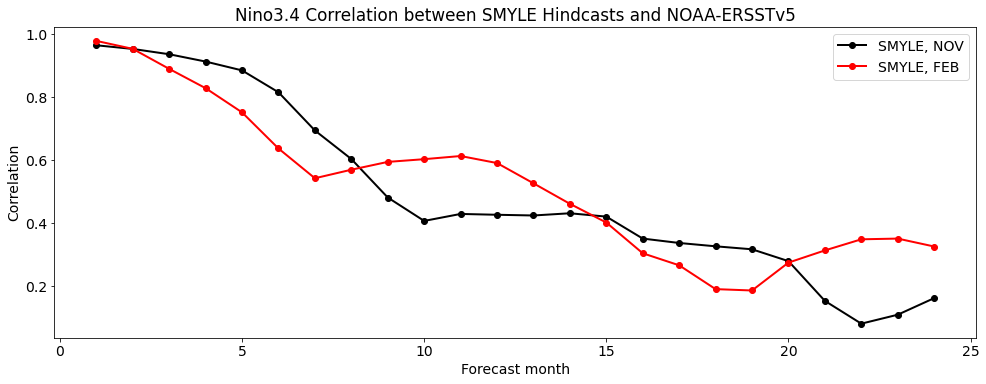

In [25]:
# plot correlation
fig = plt.figure(figsize=(16,16))
plt.rcParams['font.size'] = '14'
ax = fig.add_axes([0.1,0.7,0.8,0.27])
ax.set_ylabel('Correlation', fontsize=14)
ax.set_xlabel('Forecast month')
ax.set_title('Nino3.4 Correlation between SMYLE Hindcasts and NOAA-ERSSTv5')
ax.plot(smyle11_ccoef.L,smyle11_ccoef,color='k', marker='o',linewidth=2,label='SMYLE, NOV')
ax.plot(smyle02_ccoef.L,smyle02_ccoef,color='r', marker='o',linewidth=2,label='SMYLE, FEB')
ax.legend(loc='upper right')

### Generate RMSE Skill Plot

In [26]:
%%time
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Correlation as a function of forecast month:
smyle11_rmse   = xr.DataArray(np.zeros([smyle11_nino34.sizes['L']]), dims=['L'], coords={'L':smyle11_nino34['L']})
for i in range(smyle11_nino34.sizes['L']):
    leadindex = smyle11_nino34['L'].values[i]
    smyletime = smyle11_time_bound.sel(L=leadindex).mean('d2').rename({'Y':'time'})
    smyle_em = smyle11_nino34.sel(L=leadindex).mean('M').rename({'Y':'time'})
    obs = obs_nino34.sel(time=smyletime,method='nearest')
    smyle_em = smyle_em.assign_coords(time=("time",obs.time))
    smyle11_rmse.values[i] = rmse(smyle_em, obs)
smyle02_rmse   = xr.DataArray(np.zeros([smyle02_nino34.sizes['L']]), dims=['L'], coords={'L':smyle02_nino34['L']})
for i in range(smyle02_nino34.sizes['L']):
    leadindex = smyle02_nino34['L'].values[i]
    smyletime = smyle02_time_bound.sel(L=leadindex).mean('d2').rename({'Y':'time'})
    smyle_em = smyle02_nino34.sel(L=leadindex).mean('M').rename({'Y':'time'})
    obs = obs_nino34.sel(time=smyletime,method='nearest')
    smyle_em = smyle_em.assign_coords(time=("time",obs.time))
    smyle02_rmse.values[i] = rmse(smyle_em, obs)

CPU times: user 210 ms, sys: 707 µs, total: 211 ms
Wall time: 219 ms


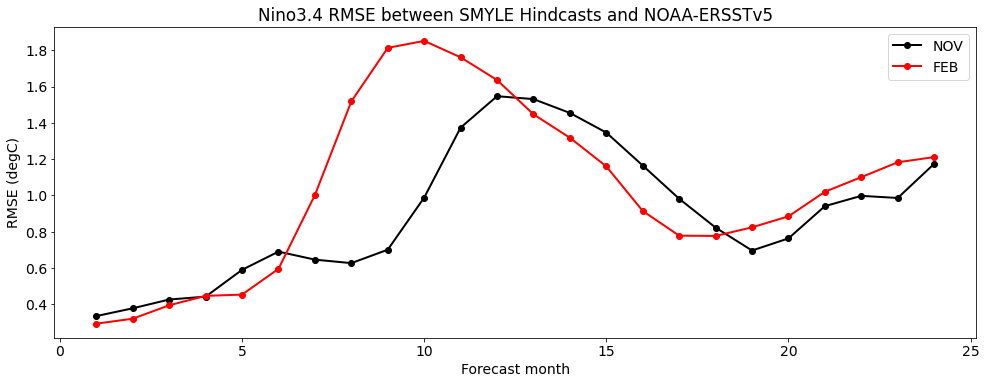

In [27]:
# plot RMSE
fig = plt.figure(figsize=(16,16))
plt.rcParams['font.size'] = '14'
ax = fig.add_axes([0.1,0.7,0.8,0.27])
ax.set_ylabel('RMSE (degC)', fontsize=14)
ax.set_xlabel('Forecast month')
ax.set_title('Nino3.4 RMSE between SMYLE Hindcasts and NOAA-ERSSTv5')
ax.plot(smyle11_rmse.L,smyle11_rmse,color='k', marker='o',linewidth=2,label='NOV')
ax.plot(smyle02_rmse.L,smyle02_rmse,color='r', marker='o',linewidth=2,label='FEB')
ax.legend(loc='upper right')

### Generate Mean Bias (Drift) Plot

In [28]:
%%time
def bias(predictions, targets):
    return ((predictions - targets).mean())

# Correlation as a function of forecast month:
smyle11_bias   = xr.DataArray(np.zeros([smyle11_nino34.sizes['L']]), dims=['L'], coords={'L':smyle11_nino34['L']})
for i in range(smyle11_nino34.sizes['L']):
    leadindex = smyle11_nino34['L'].values[i]
    smyletime = smyle11_time_bound.sel(L=leadindex).mean('d2').rename({'Y':'time'})
    smyle_em = smyle11_nino34.sel(L=leadindex).mean('M').rename({'Y':'time'})
    obs = obs_nino34.sel(time=smyletime,method='nearest')
    smyle_em = smyle_em.assign_coords(time=("time",obs.time))
    smyle11_bias.values[i] = bias(smyle_em, obs)
smyle02_bias   = xr.DataArray(np.zeros([smyle02_nino34.sizes['L']]), dims=['L'], coords={'L':smyle02_nino34['L']})
for i in range(smyle02_nino34.sizes['L']):
    leadindex = smyle02_nino34['L'].values[i]
    smyletime = smyle02_time_bound.sel(L=leadindex).mean('d2').rename({'Y':'time'})
    smyle_em = smyle02_nino34.sel(L=leadindex).mean('M').rename({'Y':'time'})
    obs = obs_nino34.sel(time=smyletime,method='nearest')
    smyle_em = smyle_em.assign_coords(time=("time",obs.time))
    smyle02_bias.values[i] = bias(smyle_em, obs)

CPU times: user 205 ms, sys: 2.32 ms, total: 208 ms
Wall time: 216 ms


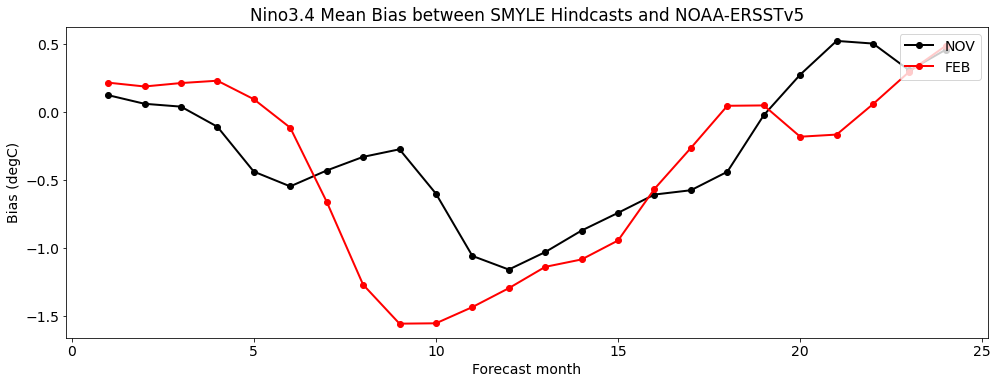

In [29]:
# plot Bias
fig = plt.figure(figsize=(16,16))
plt.rcParams['font.size'] = '14'
ax = fig.add_axes([0.1,0.7,0.8,0.27])
ax.set_ylabel('Bias (degC)', fontsize=14)
ax.set_xlabel('Forecast month')
ax.set_title('Nino3.4 Mean Bias between SMYLE Hindcasts and NOAA-ERSSTv5')
ax.plot(smyle11_bias.L,smyle11_bias,color='k', marker='o',linewidth=2,label='NOV')
ax.plot(smyle02_bias.L,smyle02_bias,color='r', marker='o',linewidth=2,label='FEB')
ax.legend(loc='upper right')